### Valuation x Financial
1. ROE x EPS
2. PB ratio ? PE ratio

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
def third_friday(date):
    month = date.month
    year = date.year
    first_day_of_month = pd.Timestamp(year, month, 1)
    first_friday = first_day_of_month + pd.offsets.Week(weekday=4)
    third_friday = first_friday + pd.offsets.Week(2)
    return third_friday

zero = pd.read_csv("0050.csv")
zero['true'] = zero['年月'].apply(lambda x: int(str(x).split("/")[1]) % 3 == 0)
zero['ticker'] = zero['標的碼'].astype(str).apply(lambda x: len(x) == 4 and x != "TT99" and x != 'MTSE')
holdings = zero[(zero['true'] == True) & (zero['ticker'] == True)]
holdings = holdings.set_index("年月")
holdings.index = pd.to_datetime(holdings.index)
holdings = holdings[holdings.index >= '2020-01-01']
try:
    holdings['標的碼'].astype(int)
except ValueError as e:
    print(e)

date_3fri = [None] * len(holdings)
for ind, i in enumerate(holdings.index):
    date_3fri[ind] = third_friday(i)
da = "da"
holdings[da] = date_3fri
holdings.set_index(da, inplace=True)
holdings.sort_index(ascending=True, inplace=True)

In [4]:
pct_close = pd.read_parquet("../../db/tw/pdata/cl_pct.parquet")
pct_close = pct_close.pct_change().dropna(how='all')
pct_close.index = pd.to_datetime(pct_close.index)
pct_close_w = pct_close
factor = pd.read_parquet('../../db/tw/pdata/pe.parquet')
factor = factor.apply(lambda x: x.str.replace(",", ""))
factor = factor.apply(lambda x: x.astype(float))

In [5]:
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    long_only_weighting = weighting[weighting > 0].fillna(0.0)*2
    return long_only_weighting

quantile = 5
time_length = len(factor)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = factor.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i:i+int(len(row)/quantile)])

pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor.columns)].shift(-1)

index = factor.index
quantiles = [None] * quantile
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = factor.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
        
        
        # factor quantilize => weighting => * pct
    weighting = get_demean_weighting(df_1)
    
    ret = pct_close_w_corres.loc[weighting.index[0]:] * weighting
    quantiles[qt_iter] = (1+ret.sum(axis=1)).cumprod() -1

[*********************100%%**********************]  1 of 1 completed


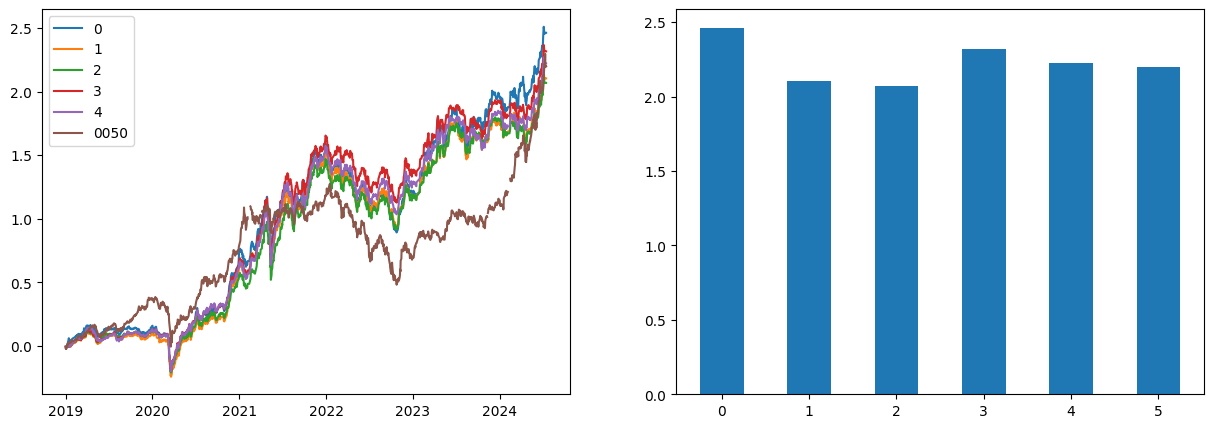

0       2.462821
1       2.104251
2       2.068926
3       2.316775
4       2.222782
0050    2.198745
Name: 2024-07-15 00:00:00, dtype: float64

In [6]:
# 全部時間段的Cumprod return
# 0 ~ 5 是 pb_ratio 從最大的最小（估值貴到便宜）
import yfinance as yf
fee = 0.001425*2 + 0.003 + 0.01
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
quantilized_cumsum = pd.DataFrame(quantiles).T
quantilized_cumsum = quantilized_cumsum*(1-fee)
z = yf.download("0050.TW", start=quantilized_cumsum.index[0])[['Adj Close']]
quantilized_cumsum['0050'] = ((1+z.pct_change()).cumprod()-1)
ax[0].plot(quantilized_cumsum, label=quantilized_cumsum.columns)
ax[0].legend()
ax[1].bar([i for i in range(len(quantilized_cumsum.columns))], [float(i) for i in quantilized_cumsum.iloc[-1, :]], width=0.5)
plt.show()
quantilized_cumsum.iloc[-1, :]

In [7]:
quantile = 10
time_length = len(factor)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = factor.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i:i+int(len(row)/quantile)])

pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor.columns)].shift(-1)
index = factor.index
quantiles = [None] * quantile

quantile_mean = quantile_df.copy()
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    for index, da_iter in enumerate(quantile_1):
        quantile_mean.iloc[index, qt_iter] = pct_close_w_corres[pct_close_w_corres.columns.intersection(da_iter)].iloc[index].mean()

<BarContainer object of 10 artists>

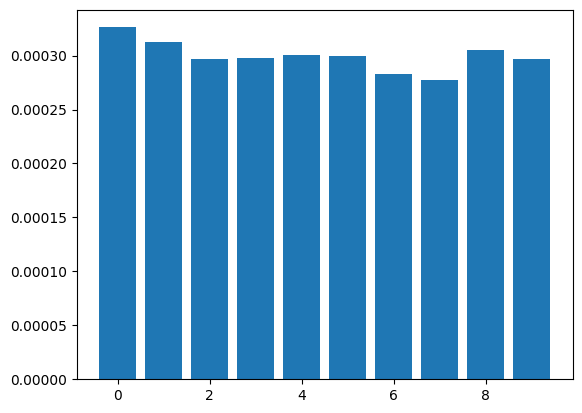

In [8]:
# 所有時間段 不同quantile的daily return mean
# 0: 估值最大的平均日報酬

plt.bar(quantile_mean.columns, quantile_mean.mean(axis=0))

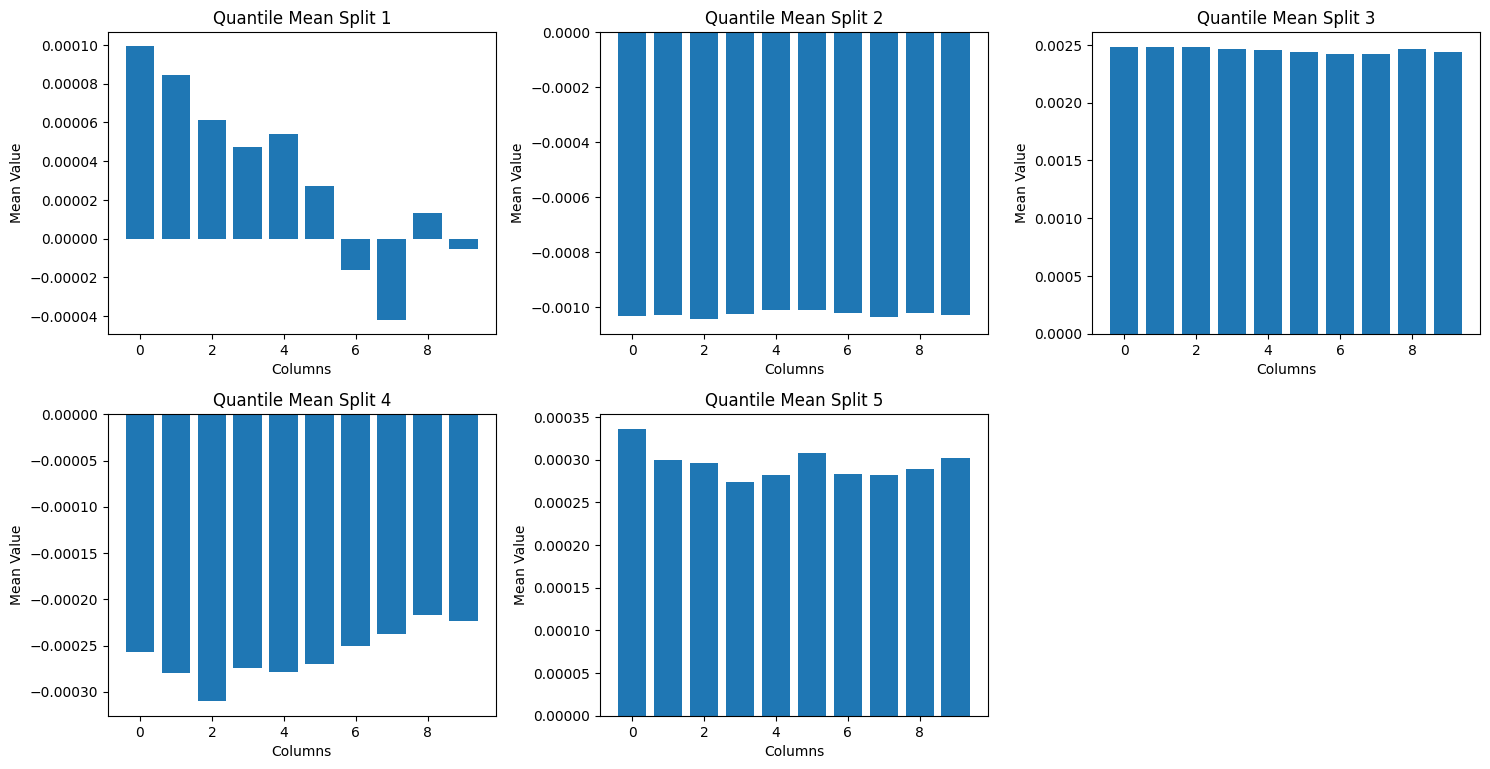

In [9]:
import numpy as np
# 以年分段的avg daily return 
num_splits = 5
split_dfs = np.array_split(quantile_mean, num_splits, axis=0)
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()

for i, df in enumerate(split_dfs):
    axes[i].bar(df.columns, df.mean(axis=0))
    axes[i].set_title(f'Quantile Mean Split {i+1}')
    axes[i].set_xlabel('Columns')
    axes[i].set_ylabel('Mean Value')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Above: pool: TWSE

### Below: pool: 0050

In [10]:
pb = pd.read_parquet('../../db/tw/pdata/pe.parquet')
pb = pb.apply(lambda x: x.str.replace(",", ""))
pb = pb.apply(lambda x: x.astype(float))

In [11]:
from datetime import datetime, timedelta
set_da = sorted(list(set(holdings.index)))
factors = [None] * (len(set_da) - 1)
for i in range(len(set_da)-1):
    start = set_da[i]
    list_ = holdings[holdings.index == start]['標的碼']
    if i != len(set_da) - 2:
        end = set_da[i+1]
    else:
        end = datetime.now()
    pct_to_be_used = pct_close_w.loc[start-timedelta(days=365-7):end]
    pct_to_be_predicted = pct_close_w.loc[start:end].index
    factor_0050_pb = pb[pb.columns.intersection(list_)].loc[start:end]
    factors[i] = factor_0050_pb
factor = pd.concat(factors).fillna(0)

[*********************100%%**********************]  1 of 1 completed

2020-03-20   -0.014891
2020-03-23    0.019351
2020-03-24    0.035920
2020-03-25    0.049435
2020-03-26    0.060498
                ...   
2024-07-09    0.232478
2024-07-10    0.232478
2024-07-11    0.232478
2024-07-12    0.232478
2024-07-15    0.232478
Length: 1077, dtype: float64
2020-03-20 00:00:00


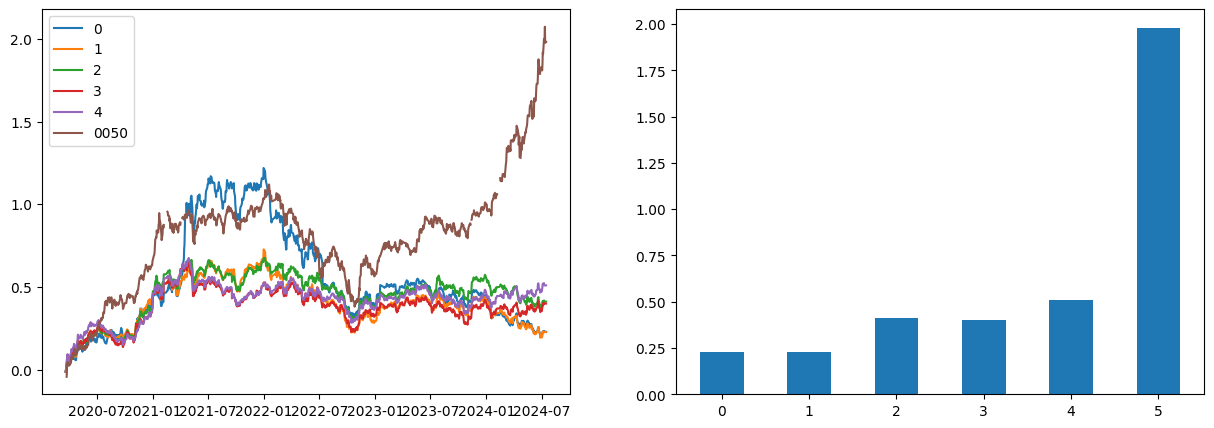

0       0.228793
1       0.226473
2       0.411454
3       0.399387
4       0.509384
0050    1.981513
Name: 2024-07-15 00:00:00, dtype: float64

In [12]:
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    long_only_weighting = weighting[weighting > 0].fillna(0.0)*2
    return long_only_weighting

quantile = 5
time_length = len(factor)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = factor.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i:i+int(len(row)/quantile)])

pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor.columns)].shift(-1)

index = factor.index
quantiles = [None] * quantile
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = factor.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
        
    weighting = get_demean_weighting(df_1)
    
    ret = pct_close_w_corres.loc[weighting.index[0]:] * weighting
    quantiles[qt_iter] = (1+ret.sum(axis=1)).cumprod() -1
print(quantiles[0])
# 全部時間段的Cumprod return
# 0 ~ 5 是 pb_ratio 從最大的最小（估值貴到便宜）
import yfinance as yf
fee = 0.001425*2 + 0.003 + 0.01
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
print(quantiles[0].index[0])
quantilized_cumsum = pd.DataFrame([q.reset_index(drop=True) for q in quantiles]).T
quantilized_cumsum.index = index
quantilized_cumsum = quantilized_cumsum*(1-fee)
z = yf.download("0050.TW", start=quantilized_cumsum.index[0])[['Adj Close']]
quantilized_cumsum['0050'] = ((1+z.pct_change()).cumprod()-1)
ax[0].plot(quantilized_cumsum, label=quantilized_cumsum.columns)
ax[0].legend()
ax[1].bar([i for i in range(len(quantilized_cumsum.columns))], [float(i) for i in quantilized_cumsum.iloc[-1, :]], width=0.5)
plt.show()
quantilized_cumsum.iloc[-1, :]

<BarContainer object of 10 artists>

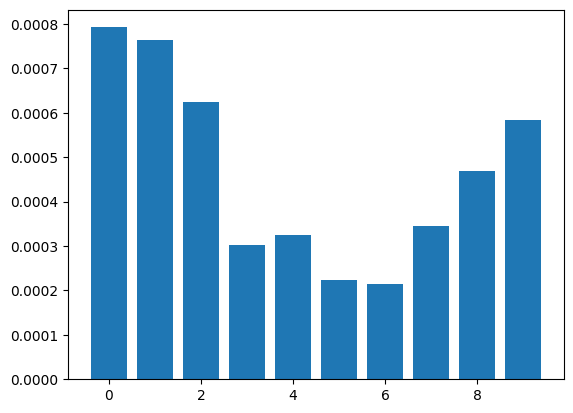

In [13]:
# 所有時間段 不同quantile的daily return mean
# 0: 估值最大的平均日報酬
quantile = 10
time_length = len(factor)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = factor.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i:i+int(len(row)/quantile)])

pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor.columns)].shift(-1)
index = factor.index
quantiles = [None] * quantile

quantile_mean = quantile_df.copy()
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    for index, da_iter in enumerate(quantile_1):
        quantile_mean.iloc[index, qt_iter] = pct_close_w_corres[pct_close_w_corres.columns.intersection(da_iter)].iloc[index].mean()
plt.bar(quantile_mean.columns, quantile_mean.mean(axis=0))

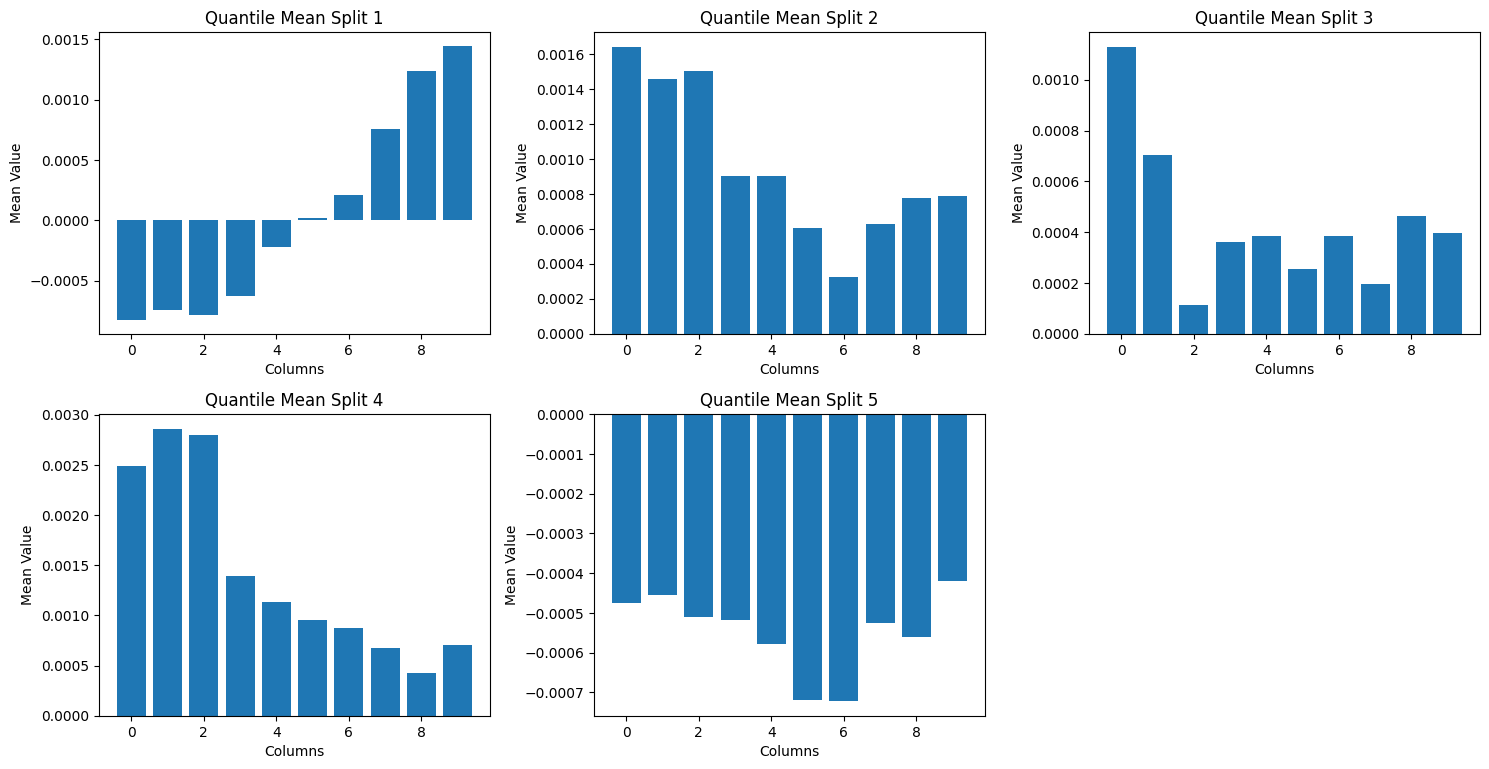

In [14]:
import numpy as np
# 以年分段的avg daily return 
num_splits = 5
split_dfs = np.array_split(quantile_mean, num_splits, axis=0)
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()

for i, df in enumerate(split_dfs):
    axes[i].bar(df.columns, df.mean(axis=0))
    axes[i].set_title(f'Quantile Mean Split {i+1}')
    axes[i].set_xlabel('Columns')
    axes[i].set_ylabel('Mean Value')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

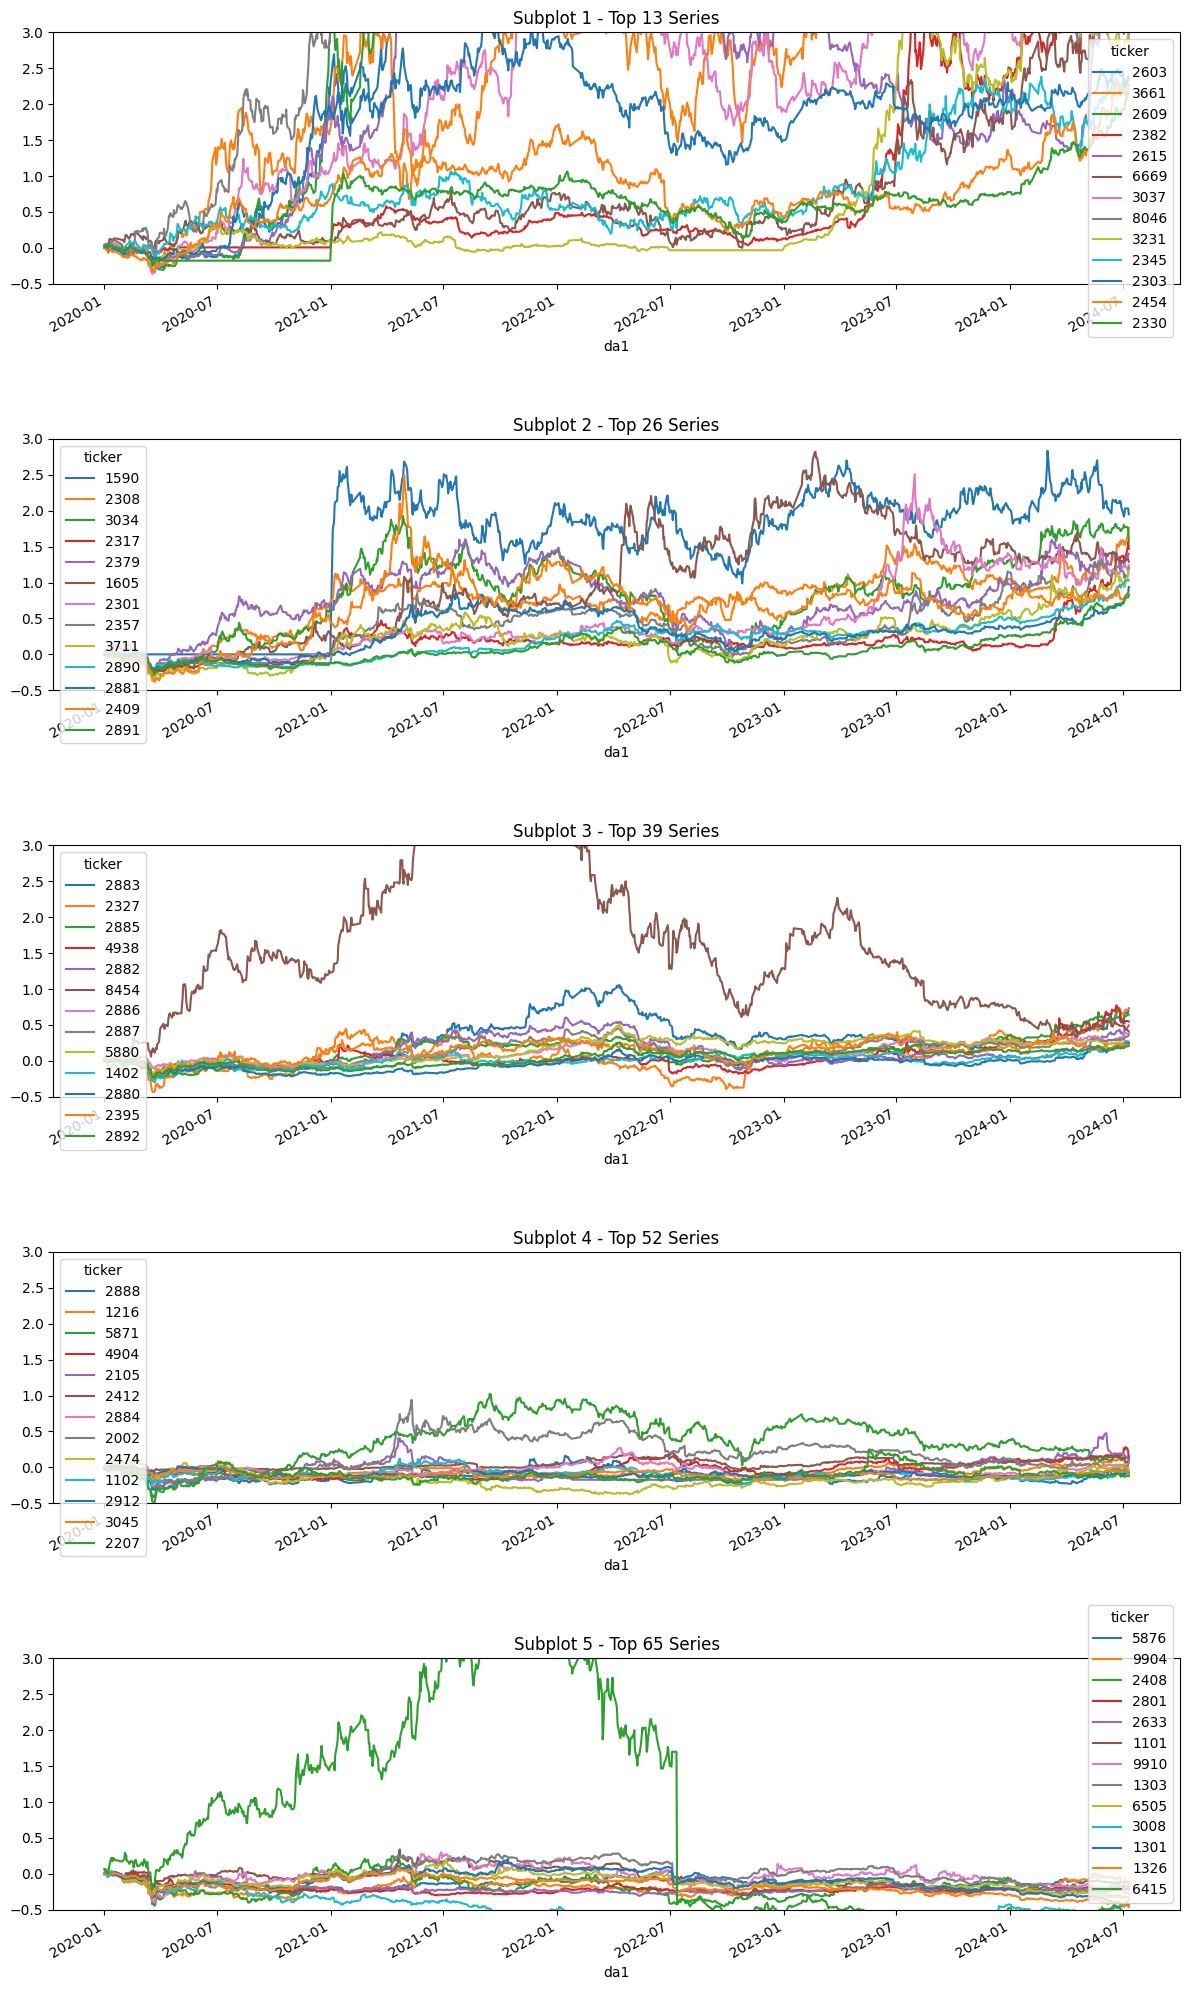

In [31]:
import matplotlib.pyplot as plt

# Calculate cumulative returns
all = pct_close_w[pct_close_w.columns.intersection(factor.columns)].loc['2020-01-01':]
all_cumsum = (1 + all).cumprod() - 1

# Sort columns by the last value
sorted_columns = all_cumsum.iloc[-1, :].sort_values(ascending=False).index

# Number of subplots
num_subplots = 5
series_per_subplot = int(len(factor.columns)/num_subplots)

# Create subplots
fig, axes = plt.subplots(num_subplots, 1, figsize=(12, 20))

for i in range(num_subplots):
    ax = axes[i]
    subset_columns = sorted_columns[i * series_per_subplot:(i + 1) * series_per_subplot]
    subset_cumsum = all_cumsum[subset_columns]
    subset_cumsum.plot(ax=ax, legend=True)
    ax.set_title(f'Subplot {i + 1} - Top {series_per_subplot * (i + 1)} Series')

plt.tight_layout()
plt.show()
